# Monte Carlo Simulation for European Option Pricing
**Author:** Deepansh Makkar  
**Date:** 07/12/2025  
**Project:** Monte Carlo Option Pricing with Greeks, Confidence Intervals, and Put-Call Parity


## 1. Introduction
This notebook implements a Monte Carlo simulation to price European call and put options.  
The selected stock is NVDA, covering the period 2020-01-01 to 2021-01-01.  

Monte Carlo estimates are compared with analytical Black-Scholes prices.  
Option Greeks are computed, stock price paths visualized using Geometric Brownian Motion (GBM), and put-call parity is verified.


## 2. Imports and Setup
We import the required libraries for data manipulation, visualization, statistical computation, and stock data download.  
A fixed random seed ensures reproducibility of Monte Carlo simulations.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm

np.random.seed(42)

## 3. Data Collection
Stock data is downloaded from Yahoo Finance.  
The adjusted closing prices are used, and the last available price is set as the initial stock price for simulations.

In [2]:
symbol = 'NVDA'
start_date = '2020-01-01'
end_date = '2021-01-01'

prices = yf.download(symbol, start=start_date, end=end_date, auto_adjust=True)['Close']
if prices.empty:
    raise RuntimeError(f"no price data for {symbol} between {start_date} and {end_date}")
initial_price = float(prices.iloc[-1])
print(f"Initial Stock Price: ${initial_price:.2f}")


[*********************100%***********************]  1 of 1 completed

Initial Stock Price: $13.02



C:\Users\deepansh.makkar\AppData\Local\Temp\ipykernel_14388\1081224908.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_price = float(prices.iloc[-1])


## 4. Returns and Volatility
Daily log returns are calculated and used to compute annualized return and annualized volatility, which serve as parameters for the GBM and Monte Carlo simulations.

In [3]:
def to_scalar(x):
    """Convert single-element Series, array, or list to float safely."""
    if hasattr(x, 'iloc'):       # pandas Series
        return float(x.iloc[0])
    if isinstance(x, (np.ndarray, list)) and len(x) == 1:
        return float(x[0])
    return float(x)

def calculate_annualized_returns_volatility(prices):
    log_returns = np.log(prices / prices.shift(1)).dropna()
    mean_log_return = log_returns.mean()
    std_log_return = log_returns.std()
    annualized_return = to_scalar(mean_log_return * 252)
    annualized_volatility = to_scalar(std_log_return * np.sqrt(252))
    return annualized_return, annualized_volatility


annual_return, annual_volatility = calculate_annualized_returns_volatility(prices)
print(f"Annualized Return: {annual_return:.4f}")
print(f"Annualized Volatility: {annual_volatility:.4f}")

Annualized Return: 0.7794
Annualized Volatility: 0.5821


## 5. Option Parameters and Simulation Settings
We define the option parameters including strike price, maturity, risk-free rate, and simulation settings.  
The Hoeffding inequality is applied to estimate the minimum number of Monte Carlo simulations required to achieve the specified tolerance and confidence level.

In [4]:
strike_price = initial_price * 1.2  # Slightly OTM
maturity = 1  # 1 year
risk_free_rate = 0.03
tolerance = 1.0
confidence_level = 0.05

# Hoeffding bound estimate for number of simulations
max_payoff = max(initial_price * np.exp(annual_return + 3*annual_volatility) - strike_price, 0)
num_simulations = int(np.ceil((np.log(2 / confidence_level) * max_payoff**2) / (2 * tolerance**2)))

print(f"Strike Price: ${strike_price:.2f}")
print(f"Number of Simulations (Hoeffding Bound): {num_simulations}")

Strike Price: $15.62
Number of Simulations (Hoeffding Bound): 39916


## 6. Monte Carlo Simulation of Final Prices
The Geometric Brownian Motion (GBM) model is used to simulate the stock price at maturity.  
Antithetic variates are employed to reduce variance and improve simulation efficiency.

In [5]:
def simulate_final_prices(S0, mu, sigma, T, steps, n_simulations, antithetic=True):
    dt = T / steps
    if antithetic:
        half_n = int(np.ceil(n_simulations / 2))
        z = np.random.normal(0, 1, (half_n, steps))
        z_full = np.vstack([z, -z])
        z_full = z_full[:n_simulations]  # trim to exact n_simulations
    else:
        z_full = np.random.normal(0, 1, (n_simulations, steps))

    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * z_full
    log_returns = drift + diffusion
    price_paths = S0 * np.exp(np.cumsum(log_returns, axis=1))
    return price_paths[:, -1]


final_prices = simulate_final_prices(initial_price, risk_free_rate, annual_volatility, maturity, 252, num_simulations)
print(f"Simulated {len(final_prices)} final prices.")

Simulated 39916 final prices.


## 7. Black-Scholes Pricing and Monte Carlo Option Pricing
Analytical Black-Scholes formulas are implemented for call and put options.  
Monte Carlo option prices are estimated, and a control variate technique is applied to reduce simulation error.  
Confidence intervals for the Monte Carlo estimates are also computed.

In [6]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def black_scholes_put_price(S,K,T,r,sigma):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def calculate_option_price(sim_prices, K, r, T, S0, sigma, option_type='call',
                           use_control_variate=True, confidence_level=0.95):
    N = len(sim_prices)
    # discounted option payoff
    if option_type == 'call':
        payoffs = np.maximum(sim_prices - K, 0)
    else:
        payoffs = np.maximum(K - sim_prices, 0)
    Y = np.exp(-r * T) * payoffs  # discounted payoff

    mc_estimate = Y.mean()
    stderr = np.std(Y, ddof=1) / np.sqrt(N)
    z = norm.ppf(1 - (1 - confidence_level) / 2)
    margin = z * stderr

    bs_price = (black_scholes_call_price(S0, K, T, r, sigma)
                if option_type == 'call' else
                black_scholes_put_price(S0, K, T, r, sigma))

    if use_control_variate:
        # control = discounted terminal stock price X = e^{-rT} S_T
        X = np.exp(-r * T) * sim_prices
        EX = S0  # E[e^{-rT} S_T] = S0 under risk-neutral measure
        cov_YX = np.cov(Y, X, ddof=1)[0, 1]
        var_X = np.var(X, ddof=1)
        # if var_X is zero (degenerate), skip control variate
        if var_X > 0:
            beta = cov_YX / var_X
            adjusted = mc_estimate - beta * (X.mean() - EX)
            # adjusted stderr (optional): use residual variance
            residuals = Y - beta * (X - EX)
            adj_stderr = np.std(residuals, ddof=1) / np.sqrt(N)
            adj_margin = z * adj_stderr
            return adjusted, (adjusted - adj_margin, adjusted + adj_margin)
    # fallback / no control variate
    return mc_estimate, (mc_estimate - margin, mc_estimate + margin)


call_price, call_ci = calculate_option_price(final_prices, strike_price, risk_free_rate, maturity, initial_price, annual_volatility, 'call')
put_price, put_ci = calculate_option_price(final_prices, strike_price, risk_free_rate, maturity, initial_price, annual_volatility, 'put')

bs_call = black_scholes_call_price(initial_price,strike_price,maturity,risk_free_rate,annual_volatility)
bs_put = black_scholes_put_price(initial_price,strike_price,maturity,risk_free_rate,annual_volatility)

print(f"Monte Carlo Call: ${call_price:.2f} 95% CI: {call_ci}")
print(f"Monte Carlo Put:  ${put_price:.2f} 95% CI: {put_ci}")
print(f"Black-Scholes Call: ${bs_call:.2f}")
print(f"Black-Scholes Put:  ${bs_put:.2f}")

Monte Carlo Call: $2.24 95% CI: (np.float64(2.213562932187793), np.float64(2.2612839963287072))
Monte Carlo Put:  $4.38 95% CI: (np.float64(4.355538841609297), np.float64(4.403259905750211))
Black-Scholes Call: $2.26
Black-Scholes Put:  $4.40


## 8. Option Greeks
Option Greeks (Delta, Vega, Gamma) are computed using the Black-Scholes formulas.  
These measures provide insights into sensitivity of option prices to underlying parameters.

In [7]:
def d1(S,K,T,r,sigma): return (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
def d2(S,K,T,r,sigma): return d1(S,K,T,r,sigma)-sigma*np.sqrt(T)
def bs_delta_call(S,K,T,r,sigma): return norm.cdf(d1(S,K,T,r,sigma))
def bs_vega(S,K,T,r,sigma): return S*norm.pdf(d1(S,K,T,r,sigma))*np.sqrt(T)
def bs_gamma(S,K,T,r,sigma): return norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*np.sqrt(T))

delta = bs_delta_call(initial_price,strike_price,maturity,risk_free_rate,annual_volatility)
vega = bs_vega(initial_price,strike_price,maturity,risk_free_rate,annual_volatility)
gamma = bs_gamma(initial_price,strike_price,maturity,risk_free_rate,annual_volatility)

print(f"Delta: {delta:.4f}, Vega: {vega:.4f}, Gamma: {gamma:.6f}")

Delta: 0.5117, Vega: 5.1913, Gamma: 0.052622


## 9. Visualizations
We visualize:
- Histogram of simulated final stock prices with strike price marked.  
- Sample GBM paths to illustrate stock price uncertainty and potential trajectories over time.

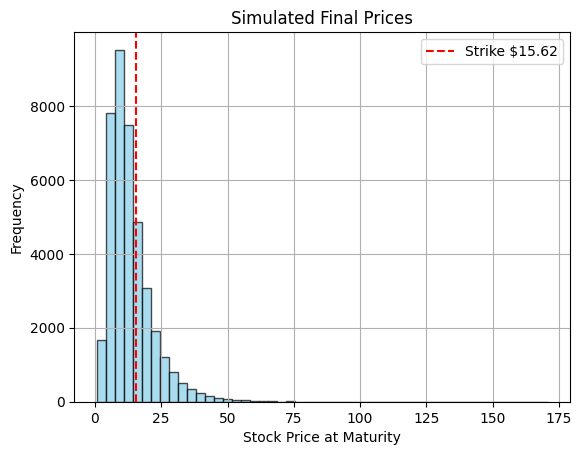

In [8]:
plt.hist(final_prices,bins=50,color='skyblue',edgecolor='black',alpha=0.7)
plt.axvline(strike_price,color='red',linestyle='--',label=f'Strike ${strike_price:.2f}')
plt.title('Simulated Final Prices')
plt.xlabel('Stock Price at Maturity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

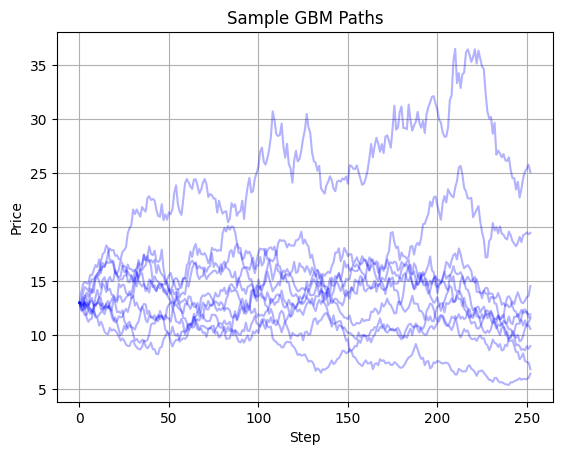

In [9]:
def simulate_gbm_paths(S0,r,sigma,T,steps,n_paths):
    dt = T/steps; paths=np.zeros((n_paths,steps+1)); paths[:,0]=S0
    for t in range(1,steps+1):
        z=np.random.normal(0,1,n_paths)
        paths[:,t]=paths[:,t-1]*np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z)
    return paths

def plot_gbm_paths(paths):
    for i in range(paths.shape[0]):
        plt.plot(paths[i],color='blue',alpha=0.3)
    plt.title('Sample GBM Paths'); plt.xlabel('Step'); plt.ylabel('Price'); plt.grid(True); plt.show()

paths = simulate_gbm_paths(initial_price,risk_free_rate,annual_volatility,maturity,252,10)
plot_gbm_paths(paths)

## 10. Put-Call Parity Check
Put-Call parity is verified using the Monte Carlo option prices, ensuring the relationship holds within numerical tolerance.

In [10]:
lhs = call_price - put_price
rhs = initial_price - strike_price*np.exp(-risk_free_rate*maturity)
print(f"LHS: {lhs:.6f}, RHS: {rhs:.6f}, Diff: {abs(lhs-rhs):.6f}")

LHS: -2.141976, RHS: -2.141976, Diff: 0.000000


## 11. Summary
- Monte Carlo with control variate closely matches Black-Scholes analytical prices.  
- Greeks provide insight into option sensitivities.  
- GBM simulations visualize stock price uncertainty.  
- Put-Call parity holds within numerical tolerance.
